In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/7/data

/content/drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/7/data


In [0]:
import numpy as np
# 데이터 부르기
x=np.loadtxt('segmentation/x_train.csv')
y=np.loadtxt('segmentation/y_train.csv')


In [0]:
x=x.T.reshape(-1,224,224,3).astype('int')
y=y.T.reshape(-1,224,224)

In [20]:
y1 = np.where(y==8,1.,0.) # 실수로 줘야 됨. 실수를 안주면, 전부 까맣게 나옴. (0~255범위 수로 인식.)
# 자동차만 볼거임. 그래서 이렇게 바꿈.
y1.shape

(367, 224, 224)

In [21]:
x = np.array(x) #확실하게 하기 위해
y2 = y1.reshape(y1.shape[0],y1.shape[1],y1.shape[2],1) # 그래서 채널이 1개짜리로 reshape 해줌. class항에 해당함.
print(x.shape, y2.shape)

# 224x 224의 binary cross entropy를 적용 중.
# 잊지말것. 아직은 instance segmentation을 하고 있다. 

(367, 224, 224, 3) (367, 224, 224, 1)


In [22]:
x = x/255
print(np.max(x))

1.0


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
base_vgg16 = VGG16(input_shape =  (224,224,3), include_top = False, weights = 'imagenet')
base_vgg16.trainable = False
base_vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [0]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Dropout, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [0]:
# 위에서 모델을 정의한 뒤에, 다시 모델 class를 써서 정의하는거임. output 자신으로만 정의.
# 중간에 dropout도 이렇게 섞어서도 쓸수있음. 계산된 값이 아니라, 구조에 관련한 것들이기 때문.

conv1 = Model(inputs=base_vgg16.input , outputs=base_vgg16.get_layer('block1_conv2').output).output
conv2 = Model(inputs=base_vgg16.input , outputs=base_vgg16.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_vgg16.input , outputs=base_vgg16.get_layer('block3_conv3').output).output
conv4 = Model(inputs=base_vgg16.input , outputs=base_vgg16.get_layer('block4_conv3').output).output # convolution + dropout이 한 세트.
drop4 = Dropout(0.5)(conv4) # 28x28x512
conv5 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block5_conv3').output).output # convolution + dropout이 한 세트.
drop5 = Dropout(0.5)(conv5) # 14x14x512

# 굉장히 유용하다. output을 받는거임. 각 모델별 input으로해서 꺼내는거임. 누적된 모형의 output을 받는거임.
# 적용만 하는거임. trainable false이기 때문.



In [0]:
# 구조가 마치 대칭적임. (즉, residual connection (skip connection이 맞을듯)을 통해 보완.) - U shape (symmetric 방법.)
# he초기값을 사용했다. 생략
# BN이 있다. 위내용들은 아니까 생략.

# 아래에 2,3,1 은 전부 filter size임. 단순함.
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(drop5)) # 28x28x512
merge6 = concatenate([drop4,up6], axis = -1) # 채널방향으로 붙임.

conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = -1)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(conv7))
merge8 = concatenate([conv2,up8],axis = -1)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = -1)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9) # 최종. 모든 채널에 대해 weight sum(=convolution)을 시행함.

In [0]:
model = Model(inputs = base_vgg16.input, outputs = conv10)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [0]:
for layer in model.layers[:18]: # vgg임. 18개의 층에대해 trainable하지 않음. 뒤쪽 층에서만 train시킬꺼임.
  layer.trainable = False

In [0]:
model.compile(optimizer=Adam(1e-3, decay = 1e-6), 
                   loss='binary_crossentropy', metrics = ['accuracy'])

In [0]:
history = model.fit(x,y2,epochs=20,batch_size=16,validation_split=0.1) 

Epoch 1/20
21/21 [==============================] - 11s 507ms/step - loss: 0.6167 - accuracy: 0.7633 - val_loss: 196.3425 - val_accuracy: 0.0533
Epoch 2/20
21/21 [==============================] - 7s 346ms/step - loss: 0.3501 - accuracy: 0.9621 - val_loss: 45.5530 - val_accuracy: 0.0623
Epoch 3/20
21/21 [==============================] - 7s 345ms/step - loss: 0.2339 - accuracy: 0.9717 - val_loss: 4.4822 - val_accuracy: 0.6791
Epoch 4/20
21/21 [==============================] - 7s 345ms/step - loss: 0.1905 - accuracy: 0.9708 - val_loss: 0.9645 - val_accuracy: 0.8822
Epoch 5/20
21/21 [==============================] - 7s 345ms/step - loss: 0.1348 - accuracy: 0.9780 - val_loss: 0.3957 - val_accuracy: 0.9729
Epoch 6/20
21/21 [==============================] - 7s 345ms/step - loss: 0.1011 - accuracy: 0.9813 - val_loss: 0.1779 - val_accuracy: 0.9766
Epoch 7/20
21/21 [==============================] - 7s 344ms/step - loss: 0.0924 - accuracy: 0.9803 - val_loss: 0.1782 - val_accuracy: 0.9776
Ep

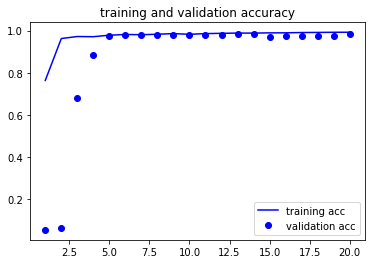

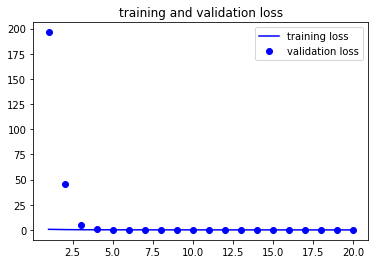

In [0]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [0]:
y_pred = model.predict(x[-2:])
y_predi = np.argmax(y_pred,axis=-1)
y_testi = y2[-2:].reshape(-1,224,224)
np.mean(y_predi == y_testi)

0.9738819355867347

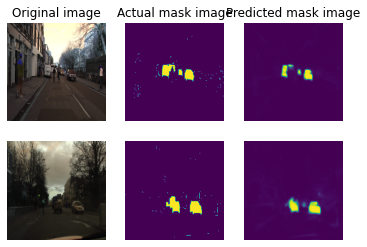

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(231)
plt.imshow(x[-1])
plt.axis('off')
plt.title('Original image')
plt.grid('off')
plt.subplot(232)
plt.imshow(y2[-1,:,:,0])
plt.axis('off')
plt.title('Actual mask image')
plt.grid('off')
plt.subplot(233)
plt.imshow(y_pred[-1,:,:,0])
plt.axis('off')
plt.title('Predicted mask image')
plt.grid('off')
plt.subplot(234)
plt.imshow(x[-2])
plt.axis('off')
plt.grid('off')
plt.subplot(235)
plt.imshow(y2[-2,:,:,0])
plt.axis('off')
plt.grid('off')
plt.subplot(236)
plt.imshow(y_pred[-2,:,:,0])
plt.axis('off')
plt.grid('off')
plt.show()

In [0]:
from tensorflow.keras.utils import plot_model

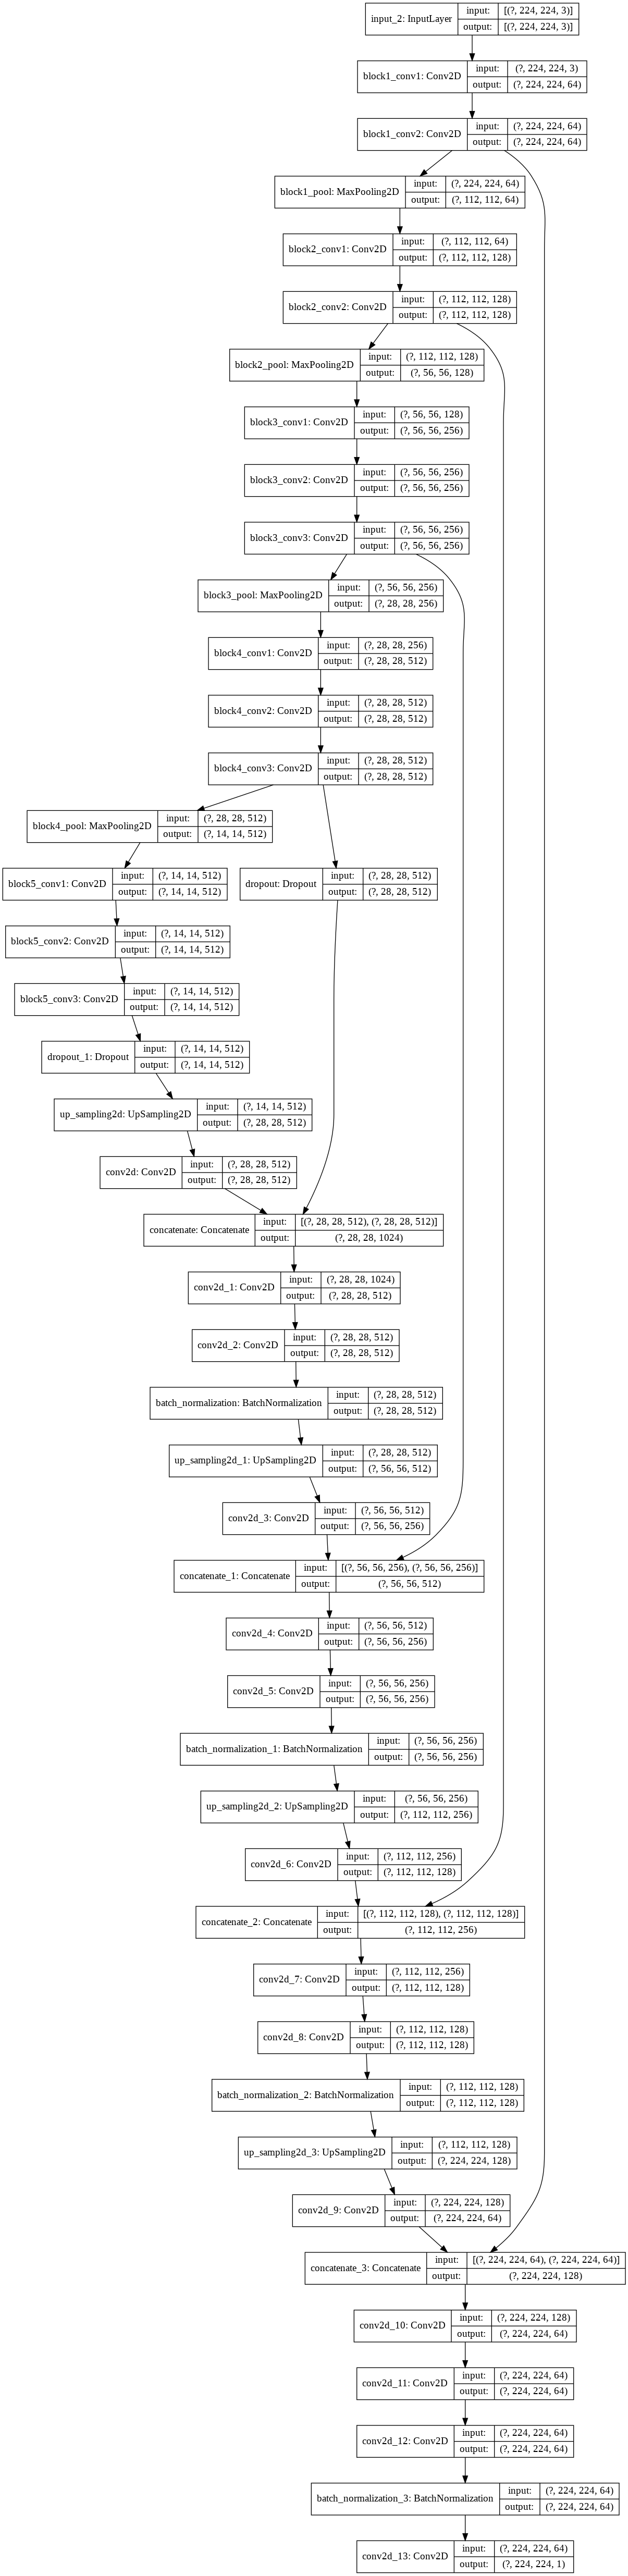

In [0]:
from IPython.display import Image
Image(retina=True, filename='model.png') # 모델을 보여주는 메서드인듯.


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
base_vgg16 = VGG16(input_shape =  (224,224,3), include_top = False, weights = 'imagenet')
base_vgg16.trainable = False
base_vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [0]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Dropout, concatenate, BatchNormalization, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [0]:
# 위에서 모델을 정의한 뒤에, 다시 모델 class를 써서 정의하는거임. output 자신으로만 정의.
# 중간에 dropout도 이렇게 섞어서도 쓸수있음. 계산된 값이 아니라, 구조에 관련한 것들이기 때문.

conv1 = Model(inputs=base_vgg16.input , outputs=base_vgg16.get_layer('block1_conv2').output).output
conv2 = Model(inputs=base_vgg16.input , outputs=base_vgg16.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_vgg16.input , outputs=base_vgg16.get_layer('block3_conv3').output).output
conv4 = Model(inputs=base_vgg16.input , outputs=base_vgg16.get_layer('block4_conv3').output).output # convolution + dropout이 한 세트.
drop4 = Dropout(0.5)(conv4) # 28x28x512
conv5 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block5_conv3').output).output # convolution + dropout이 한 세트.
drop5 = Dropout(0.5)(conv5) # 14x14x512

# 굉장히 유용하다. output을 받는거임. 각 모델별 input으로해서 꺼내는거임. 누적된 모형의 output을 받는거임.
# 적용만 하는거임. trainable false이기 때문.



In [0]:
# 구조가 마치 대칭적임. (즉, residual connection (skip connection이 맞을듯)을 통해 보완.) - U shape (symmetric 방법.)
# he초기값을 사용했다. 생략
# BN이 있다. 위내용들은 아니까 생략.

# 아래에 2,3,1 은 전부 filter size임. 단순함.
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(Conv2DTranspose(512,kernel_size =(3,3),strides=2,padding='same')(drop5)) # 28x28x512
merge6 = concatenate([drop4,up6], axis = -1) # 채널방향으로 붙임.

conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(Conv2DTranspose(256,kernel_size =(3,3),strides=2,padding='same')(conv6))
merge7 = concatenate([conv3,up7], axis = -1)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(Conv2DTranspose(128,kernel_size =(3,3),strides=2,padding='same')(conv7))
merge8 = concatenate([conv2,up8],axis = -1)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(Conv2DTranspose(64,kernel_size =(3,3),strides=2,padding='same')(conv8))
merge9 = concatenate([conv1,up9], axis = -1)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9) # 최종. 모든 채널에 대해 weight sum(=convolution)을 시행함.

In [13]:
model = Model(inputs = base_vgg16.input, outputs = conv10)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [0]:
for layer in model.layers[:18]: # vgg임. 18개의 층에대해 trainable하지 않음. 뒤쪽 층에서만 train시킬꺼임.
  layer.trainable = False

In [0]:
model.compile(optimizer=Adam(1e-3, decay = 1e-6), 
                   loss='binary_crossentropy', metrics = ['accuracy'])

In [23]:
history = model.fit(x,y2,epochs=20,batch_size=16,validation_split=0.1) 

Epoch 1/20
21/21 [==============================] - 24s 1s/step - loss: 0.5707 - accuracy: 0.8232 - val_loss: 166.4194 - val_accuracy: 0.0533
Epoch 2/20
21/21 [==============================] - 16s 770ms/step - loss: 0.3183 - accuracy: 0.9676 - val_loss: 17.0086 - val_accuracy: 0.1495
Epoch 3/20
21/21 [==============================] - 16s 774ms/step - loss: 0.2039 - accuracy: 0.9767 - val_loss: 2.1223 - val_accuracy: 0.8766
Epoch 4/20
21/21 [==============================] - 16s 780ms/step - loss: 0.1474 - accuracy: 0.9798 - val_loss: 0.1406 - val_accuracy: 0.9767
Epoch 5/20
21/21 [==============================] - 16s 784ms/step - loss: 0.1413 - accuracy: 0.9769 - val_loss: 1.0973 - val_accuracy: 0.9354
Epoch 6/20
21/21 [==============================] - 17s 787ms/step - loss: 0.1065 - accuracy: 0.9801 - val_loss: 0.1730 - val_accuracy: 0.9810
Epoch 7/20
21/21 [==============================] - 17s 791ms/step - loss: 0.0805 - accuracy: 0.9833 - val_loss: 0.1065 - val_accuracy: 0.9779

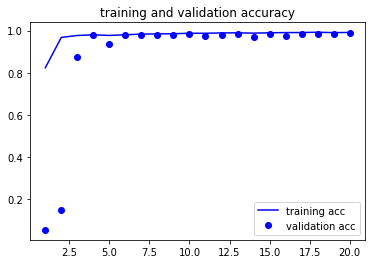

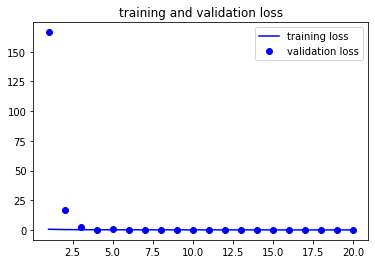

In [24]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [28]:
y_pred = model.predict(x[-2:])
y_predi = np.argmax(y_pred,axis=-1)
y_testi = y2[-2:].reshape(-1,224,224)
np.mean(y_predi == y_testi)

0.9738819355867347

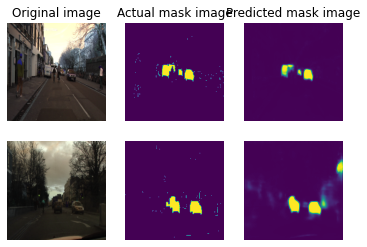

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(231)
plt.imshow(x[-1])
plt.axis('off')
plt.title('Original image')
plt.grid('off')
plt.subplot(232)
plt.imshow(y2[-1,:,:,0])
plt.axis('off')
plt.title('Actual mask image')
plt.grid('off')
plt.subplot(233)
plt.imshow(y_pred[-1,:,:,0])
plt.axis('off')
plt.title('Predicted mask image')
plt.grid('off')
plt.subplot(234)
plt.imshow(x[-2])
plt.axis('off')
plt.grid('off')
plt.subplot(235)
plt.imshow(y2[-2,:,:,0])
plt.axis('off')
plt.grid('off')
plt.subplot(236)
plt.imshow(y_pred[-2,:,:,0])
plt.axis('off')
plt.grid('off')
plt.show()

In [0]:
from tensorflow.keras.utils import plot_model

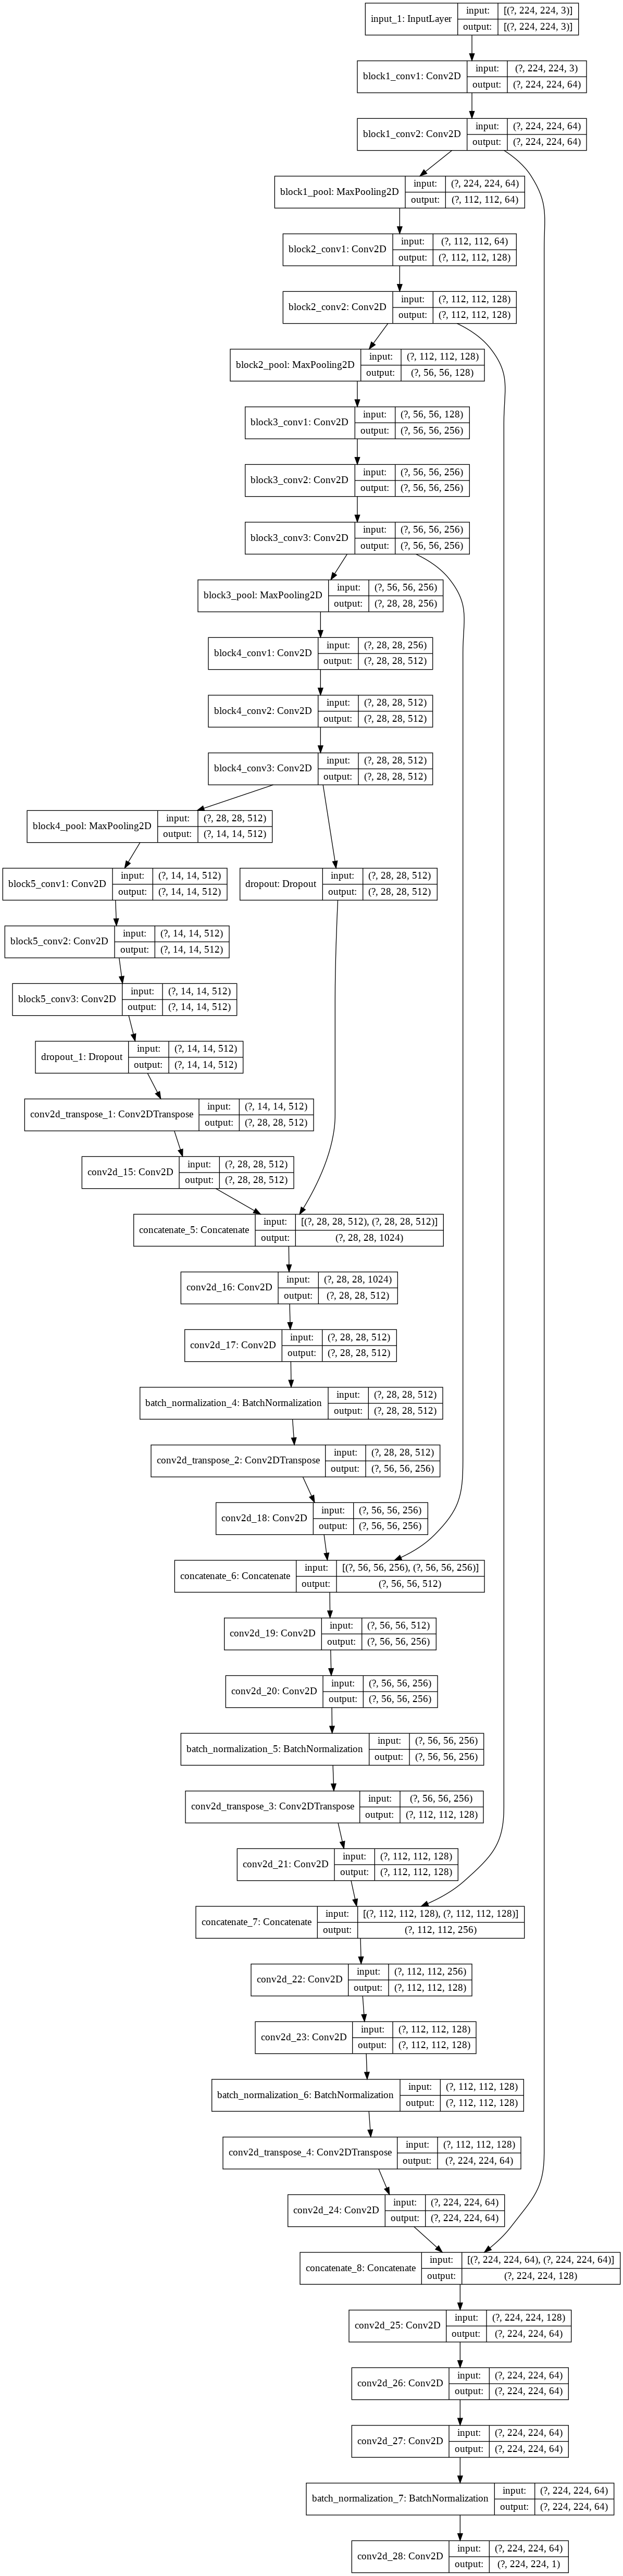

In [17]:
from IPython.display import Image
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png') # 모델을 보여주는 메서드인듯.
